# Object detection on post images

In [107]:
import os
import urllib
import tarfile
import numpy as np

In [108]:
import matplotlib.pyplot as plt

%matplotlib inline

In [109]:
import tensorflow as tf

from distutils.version import StrictVersion

print('Using tensorflow version {0}'.format(tf.__version__))


Using tensorflow version 1.9.0


In [110]:
MODEL_DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12'
MODEL_FILE = MODEL_NAME + '.tar.gz'

if os.path.exists(MODEL_FILE) is False:
    opener = urllib.request.URLopener()
    opener.retrieve(MODEL_DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

In [111]:
BOX_DESCRIPTIONS_FILE = 'class-descriptions-boxable.csv'
OID_DOWNLOAD_BASE = 'https://storage.googleapis.com/openimages/2018_04/'

if os.path.exists(BOX_DESCRIPTIONS_FILE) is False:
    opener = urllib.request.URLopener()
    opener.retrieve(OID_DOWNLOAD_BASE + BOX_DESCRIPTIONS_FILE, BOX_DESCRIPTIONS_FILE)

In [112]:
TEST_IMAGES = {
    'cat.jpg': 'https://c2.staticflickr.com/7/6118/6370710013_cb6b0270d3_o.jpg',
    'dog.jpg': 'https://c3.staticflickr.com/1/92/246323809_f8a8ab71fe_o.jpg',
    'pets.jpg': 'https://live.staticflickr.com/3273/2982384735_eeecaf03f2_b.jpg',
    'lion.jpg': '',
    'football.jpg': '',
}

for filename, url in TEST_IMAGES.items():
    if os.path.exists(filename) is False:
        opener = urllib.request.URLopener()
        opener.retrieve(url, filename)

In [113]:
FROZEN_GRAPH_FILE = 'frozen_inference_graph.pb'
PATH_TO_FROZEN_GRAPH = os.path.join(MODEL_NAME, FROZEN_GRAPH_FILE)

if os.path.exists(MODEL_NAME) is False:
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        filename = os.path.basename(file.name)
        if FROZEN_GRAPH_FILE in filename:
            tar_file.extract(file, os.getcwd())

In [114]:
import pandas as pd

ID_KEY = 'id'
CLASS_KEY = 'class'
NAME_KEY = 'name'

df = pd.read_csv(BOX_DESCRIPTIONS_FILE, names=[ID_KEY, CLASS_KEY])
category_index = {}
embeding_dict = {}
for idx, row in df.iterrows():
    category_index[idx+1] = {ID_KEY: row[ID_KEY], NAME_KEY: row[CLASS_KEY]}
    embeding_dict[row[CLASS_KEY]] = 0

In [115]:
category_index

{1: {'id': '/m/011k07', 'name': 'Tortoise'},
 2: {'id': '/m/011q46kg', 'name': 'Container'},
 3: {'id': '/m/012074', 'name': 'Magpie'},
 4: {'id': '/m/0120dh', 'name': 'Sea turtle'},
 5: {'id': '/m/01226z', 'name': 'Football'},
 6: {'id': '/m/012n7d', 'name': 'Ambulance'},
 7: {'id': '/m/012w5l', 'name': 'Ladder'},
 8: {'id': '/m/012xff', 'name': 'Toothbrush'},
 9: {'id': '/m/012ysf', 'name': 'Syringe'},
 10: {'id': '/m/0130jx', 'name': 'Sink'},
 11: {'id': '/m/0138tl', 'name': 'Toy'},
 12: {'id': '/m/013y1f', 'name': 'Organ'},
 13: {'id': '/m/01432t', 'name': 'Cassette deck'},
 14: {'id': '/m/014j1m', 'name': 'Apple'},
 15: {'id': '/m/014sv8', 'name': 'Human eye'},
 16: {'id': '/m/014trl', 'name': 'Cosmetics'},
 17: {'id': '/m/014y4n', 'name': 'Paddle'},
 18: {'id': '/m/0152hh', 'name': 'Snowman'},
 19: {'id': '/m/01599', 'name': 'Beer'},
 20: {'id': '/m/01_5g', 'name': 'Chopsticks'},
 21: {'id': '/m/015h_t', 'name': 'Human beard'},
 22: {'id': '/m/015p6', 'name': 'Bird'},
 23: {'id':

In [116]:
embeding_dict

{'Tortoise': 0,
 'Container': 0,
 'Magpie': 0,
 'Sea turtle': 0,
 'Football': 0,
 'Ambulance': 0,
 'Ladder': 0,
 'Toothbrush': 0,
 'Syringe': 0,
 'Sink': 0,
 'Toy': 0,
 'Organ': 0,
 'Cassette deck': 0,
 'Apple': 0,
 'Human eye': 0,
 'Cosmetics': 0,
 'Paddle': 0,
 'Snowman': 0,
 'Beer': 0,
 'Chopsticks': 0,
 'Human beard': 0,
 'Bird': 0,
 'Parking meter': 0,
 'Traffic light': 0,
 'Croissant': 0,
 'Cucumber': 0,
 'Radish': 0,
 'Towel': 0,
 'Doll': 0,
 'Skull': 0,
 'Washing machine': 0,
 'Glove': 0,
 'Tick': 0,
 'Belt': 0,
 'Sunglasses': 0,
 'Banjo': 0,
 'Cart': 0,
 'Ball': 0,
 'Backpack': 0,
 'Bicycle': 0,
 'Home appliance': 0,
 'Centipede': 0,
 'Boat': 0,
 'Surfboard': 0,
 'Boot': 0,
 'Headphones': 0,
 'Hot dog': 0,
 'Shorts': 0,
 'Fast food': 0,
 'Bus': 0,
 'Boy': 0,
 'Screwdriver': 0,
 'Bicycle wheel': 0,
 'Barge': 0,
 'Laptop': 0,
 'Miniskirt': 0,
 'Drill': 0,
 'Dress': 0,
 'Bear': 0,
 'Waffle': 0,
 'Pancake': 0,
 'Brown bear': 0,
 'Woodpecker': 0,
 'Blue jay': 0,
 'Pretzel': 0,
 'Ba

In [117]:
graph = tf.Graph()
with graph.as_default():
    graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(graph_def, name='')

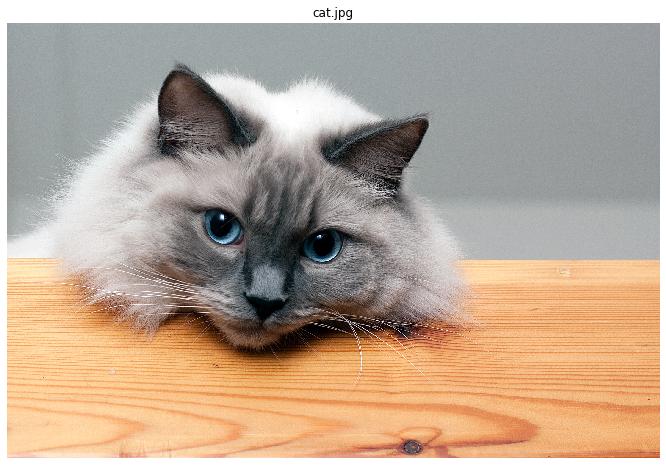

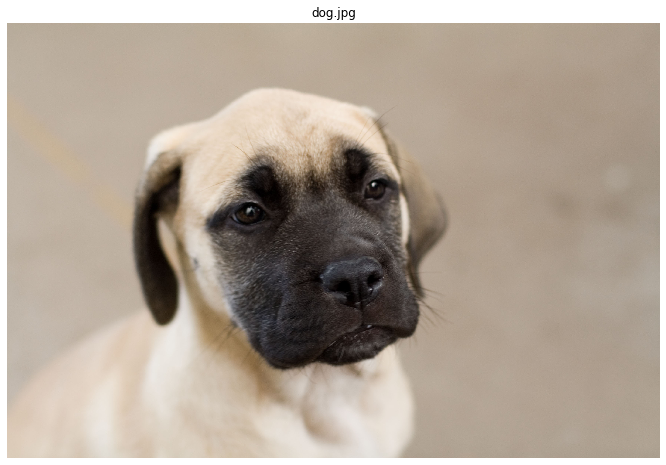

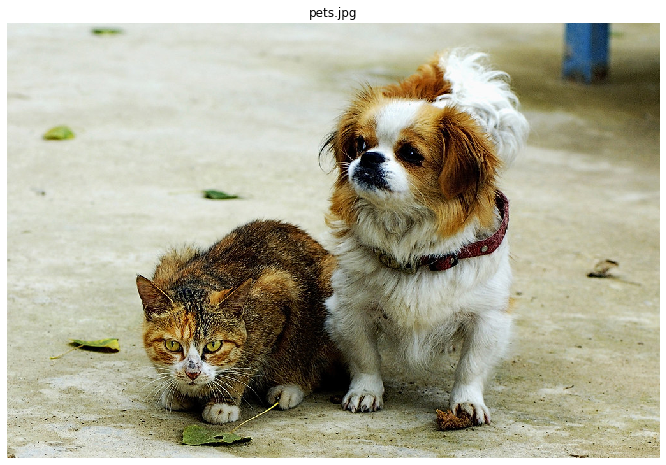

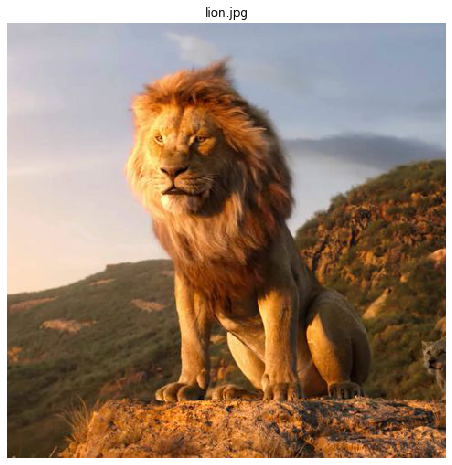

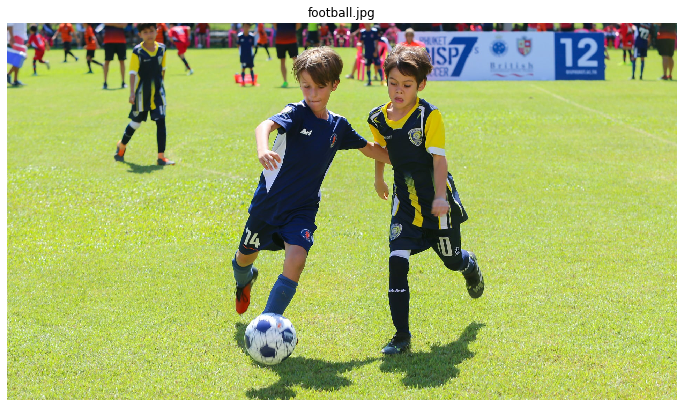

In [118]:
from PIL import Image

IMAGE_SIZE = (12, 8)


def show_image(filename, image):
    
    plt.figure(figsize=IMAGE_SIZE)
    plt.title(filename)
    plt.axis('off')
    plt.imshow(image)


for filename, _ in TEST_IMAGES.items():
    original_image = Image.open(filename)
    show_image(filename, original_image)

In [119]:
# Font to draw text on image
FONT_NAME = 'Ubuntu-R.ttf'

# Bounding box colors
COLORS = ['Green',
          'Red', 'Pink',
          'Olive', 'Brown', 'Gray',
          'Cyan', 'Orange']

In [120]:
class ObjectResult:

    def __init__(self, label, score, box):
        self.label = label
        self.score = score
        self.box = box
    
    def __repr__(self):
        return '{0} ({1}%)'.format(self.label, int(100 * self.score))

In [121]:
N_CHANNELS = 3

def load_image_into_numpy_array(image):
    
    (width, height) = image.size
    return np.array(image.getdata()).reshape((height, width, N_CHANNELS)).astype(np.uint8)

In [122]:
def process_output(classes, scores, boxes, category_index):

    results = []

    for clazz, score, box in zip(classes, scores, boxes):
        if score > 0.0:
            label = category_index[clazz][NAME_KEY]
            obj_result = ObjectResult(label, score, box)
            results.append(obj_result)
    
    return results

In [123]:
import random
import PIL.Image as Image

def draw_labeled_boxes(image_np, results, min_score=.4):

    results.sort(key=lambda x: x.score, reverse=False)
    image_np_copy = image_np.copy()
    for r in results:
        if r.score >= min_score:
            color_idx = random.randint(0, len(COLORS) - 1)
            color = COLORS[color_idx]

            image_pil = Image.fromarray(np.uint8(image_np_copy)).convert('RGB')
            draw_bounding_box_on_image(image_pil, r.box, color, str(r))
            np.copyto(image_np_copy, np.array(image_pil))

    return image_np_copy

In [124]:
import PIL.ImageFont as ImageFont

def get_suitable_font_for_text(text, img_width, font_name, img_fraction=0.12):
    fontsize = 1
    font = ImageFont.truetype(FONT_NAME, fontsize)
    while font.getsize(text)[0] < img_fraction*img_width:
        fontsize += 1
        font = ImageFont.truetype(font_name, fontsize)
    return font

In [125]:
import PIL.ImageDraw as ImageDraw

TEXT_COLOR = 'Black'

def draw_bounding_box_on_image(image, box, color, box_label):
    im_width, im_height = image.size
    top, left, bottom, right = box

    # Normalize coordinates
    left = left * im_width
    right = right * im_width
    top = top * im_height
    bottom = bottom * im_height

    # Draw the detected bounding box
    line_width = int(max(im_width, im_height) * 0.005)
    draw = ImageDraw.Draw(image)
    draw.rectangle(((left, top), (right, bottom)),
                   width=line_width,
                   outline=color)

    # Get a suitable font (in terms of size with respect to the image)
    font = get_suitable_font_for_text(box_label, im_width, FONT_NAME)
    text_width, text_height = font.getsize(box_label)

    # Draw the box label rectangle
    text_bottom = top + text_height
    text_rect = ((left, top),
                 (left + text_width + 2 * line_width,
                  text_bottom + 2 * line_width))
    draw.rectangle(text_rect, fill=color)

    # Draw the box label text 
    # right below the upper-left horizontal line of the bounding box
    text_position = (left + line_width, top + line_width)
    draw.text(text_position, box_label, fill=TEXT_COLOR, font=font)

In [126]:
# Input tensor
IMAGE_TENSOR_KEY = 'image_tensor'

# Output tensors
DETECTION_BOXES_KEY = 'detection_boxes'
DETECTION_SCORES_KEY = 'detection_scores'
DETECTION_CLASSES_KEY = 'detection_classes'

TENSOR_SUFFIX = ':0'

def run_inference(graph, image_np):
    
    output_tensor_dict = {
        DETECTION_BOXES_KEY: DETECTION_BOXES_KEY + TENSOR_SUFFIX,
        DETECTION_SCORES_KEY: DETECTION_SCORES_KEY + TENSOR_SUFFIX,
        DETECTION_CLASSES_KEY: DETECTION_CLASSES_KEY + TENSOR_SUFFIX
    }

    with graph.as_default():
        with tf.Session() as sess:
            input_tensor = tf.get_default_graph().get_tensor_by_name(IMAGE_TENSOR_KEY + TENSOR_SUFFIX)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            input_tensor_dict = {input_tensor: image_np_expanded}
            output_dict = sess.run(output_tensor_dict, feed_dict=input_tensor_dict)

            return {
                DETECTION_BOXES_KEY: 
                    output_dict[DETECTION_BOXES_KEY][0],
                DETECTION_SCORES_KEY: 
                    output_dict[DETECTION_SCORES_KEY][0],
                DETECTION_CLASSES_KEY: 
                    output_dict[DETECTION_CLASSES_KEY][0].astype(np.int64)
            }

In [127]:
IMAGE_NP_KEY = 'image_np'
RESULTS_KEY = 'results'

file_result_dict = {}

for filename, _ in TEST_IMAGES.items():
    
    if filename in file_result_dict.keys():
        continue
    
    print(filename)
    
    image_np = load_image_into_numpy_array(Image.open(filename))
    
    output_dict = run_inference(graph, image_np)
 
    results = process_output(output_dict[DETECTION_CLASSES_KEY],
                             output_dict[DETECTION_SCORES_KEY],
                             output_dict[DETECTION_BOXES_KEY],
                             category_index)

    file_result_dict[filename] = { IMAGE_NP_KEY: image_np, RESULTS_KEY: results }

cat.jpg
dog.jpg
pets.jpg
lion.jpg
football.jpg


[Cat (99%)]
[Dog (99%)]
[Cat (95%), Dog (99%)]
[Carnivore (33%), Lion (95%)]
[Person (31%), Person (31%), Person (32%), Person (33%), Person (36%), Person (37%), Footwear (44%), Person (53%), Footwear (56%), Footwear (69%), Boy (78%), Football (95%)]


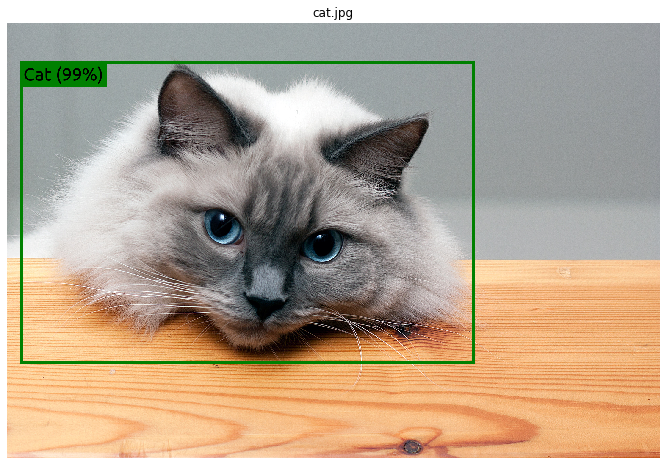

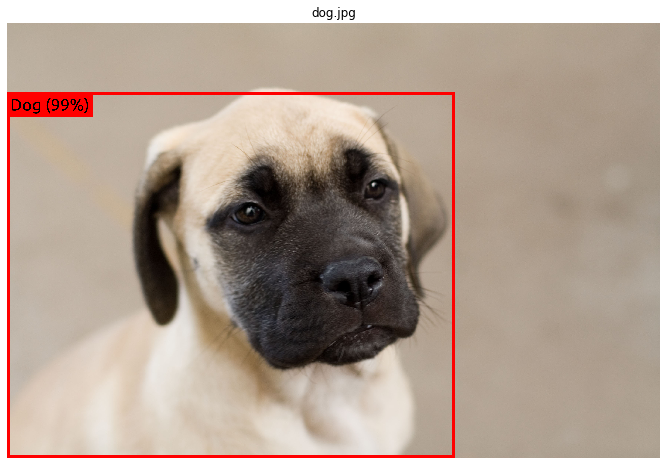

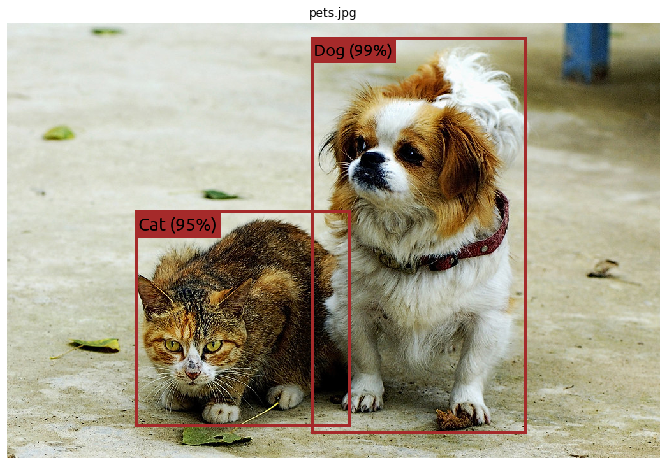

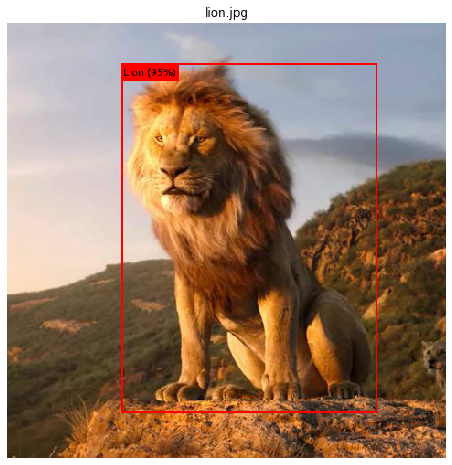

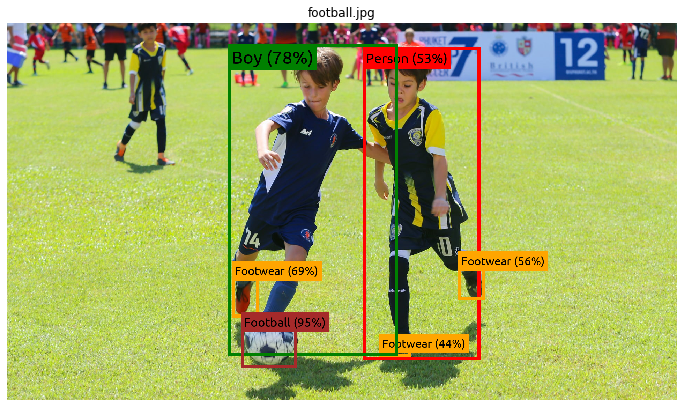

In [97]:
for filename, img_results_dict in file_result_dict.items():
    processed_image = draw_labeled_boxes(img_results_dict[IMAGE_NP_KEY], img_results_dict[RESULTS_KEY])
    show_image(filename, processed_image)
    print(img_results_dict[RESULTS_KEY])

In [98]:
filename = 'football.jpg'

image_np = load_image_into_numpy_array(Image.open(filename))

output_dict = run_inference(graph, image_np)

results = process_output(output_dict[DETECTION_CLASSES_KEY],
                         output_dict[DETECTION_SCORES_KEY],
                         output_dict[DETECTION_BOXES_KEY],
                         category_index)

file_result_dict[filename] = { IMAGE_NP_KEY: image_np, RESULTS_KEY: results }

[Person (31%), Person (31%), Person (32%), Person (33%), Person (36%), Person (37%), Footwear (44%), Person (53%), Footwear (56%), Footwear (69%), Boy (78%), Football (95%)]


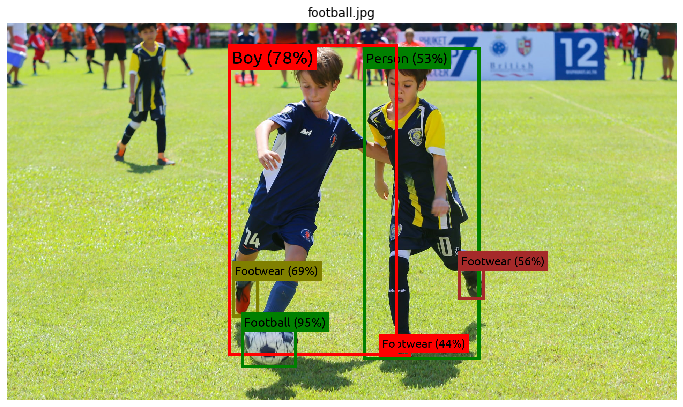

In [99]:
processed_image = draw_labeled_boxes(file_result_dict[filename][IMAGE_NP_KEY], file_result_dict[filename][RESULTS_KEY])
show_image(filename, processed_image)
print(img_results_dict[RESULTS_KEY])

In [100]:
import copy

help_dict = copy.deepcopy(embeding_dict)

for item in img_results_dict[RESULTS_KEY]:
    if item.score > 0.4:
        help_dict[item.label] += 1

help_dict
help_dict.values()

dict_values([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [101]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pytesseract

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 16,12

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

'TALK TO ANOTHER SOCIALLY\nAWKWARD PENGUIN\n\n?\n\nBECOME SOCIALLY AWESOME\nPENGUINS'

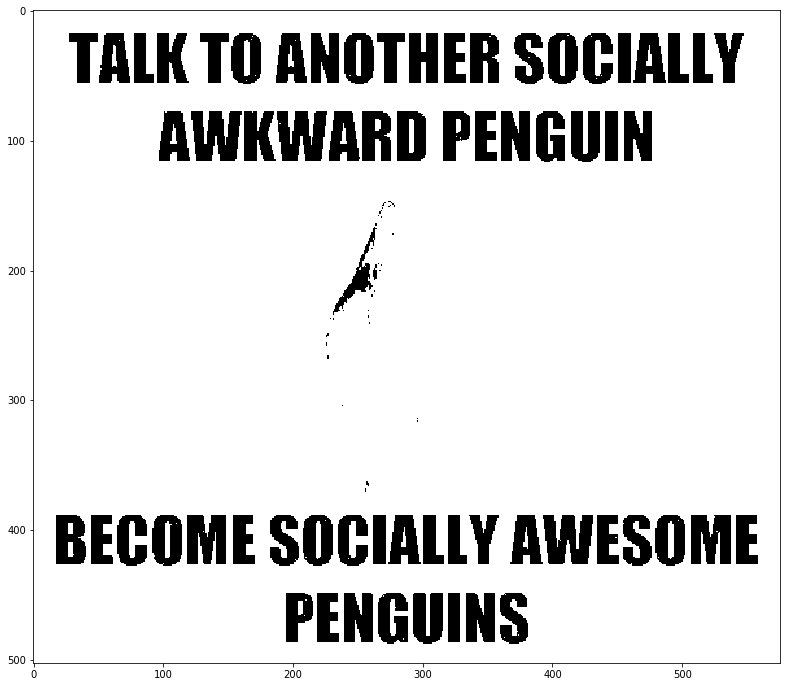

In [102]:
img = cv2.imread('images-text/sap1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

img_bin = img_gray > 240
img_inv = 255 - img_bin

plt.imshow(img_inv, 'gray')

custom_config = r'--oem 1 --psm 1'
pytesseract.image_to_string(img_inv, config=custom_config)

In [103]:
def ocr_pattern_image(image_name):
    img = cv2.imread('images-text/' + image_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    img_bin = img_gray > 240
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

    # img_bin = cv2.dilate(img_bin.astype('uint8'), kernel, iterations=1)
    img_bin = cv2.erode(img_bin.astype('uint8'), kernel, iterations=1)
    img_bin = cv2.dilate(img_bin.astype('uint8'), kernel, iterations=1)
    
    # img_bin = cv2.GaussianBlur(img_bin,(3,3),cv2.BORDER_DEFAULT)
    
    # Sharpening
    # kernel_sharpen = np.array([[-1,-1,-1], [-1,27,-1], [-1,-1,-1]])
    # img_bin = cv2.filter2D(img_bin, -1, kernel_sharpen)
    
    img_inv = 255 - img_bin
    
    plt.imshow(img_inv, 'gray')
    
    custom_config = r'--oem 1 --psm 1'
    return pytesseract.image_to_string(img_inv, config=custom_config)

TALK TO ANOTHER SOCIALLY
AWKWARD PENGUIN

7

-

BECOME SOCIALLY AWESOME
PENGUINS


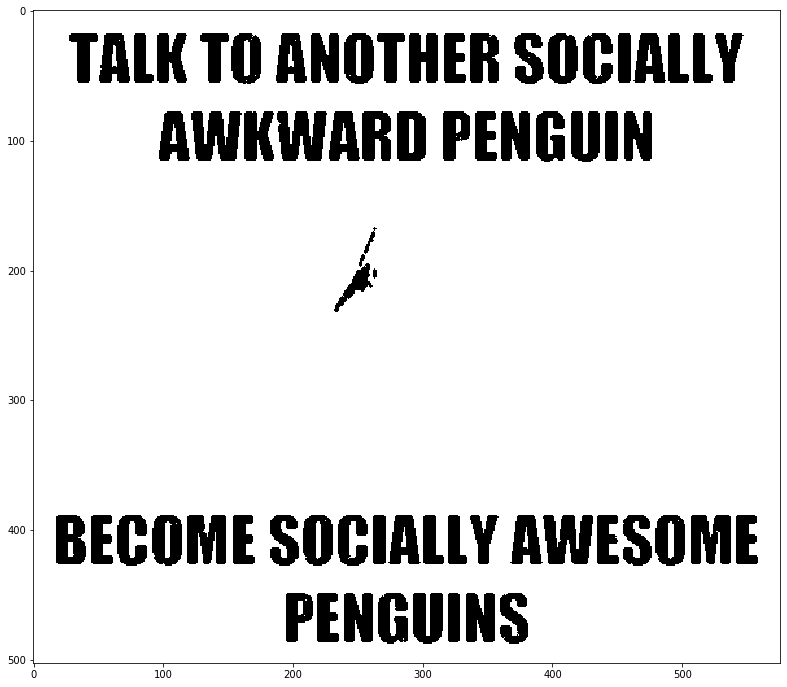

In [104]:
text = ocr_pattern_image('sap1.jpg')
print(text)

In [105]:
from os import listdir
listdir('images-text')

['img1.jpg',
 'pr.jpg',
 'pr2.jpg',
 'pr3.jpg',
 'sap1.jpg',
 'sap2.jpg',
 'sap3.jfif',
 'sap4.jpg',
 'text1.webp',
 'wi1.jfif',
 'wi2.jpg',
 'wi3.png']

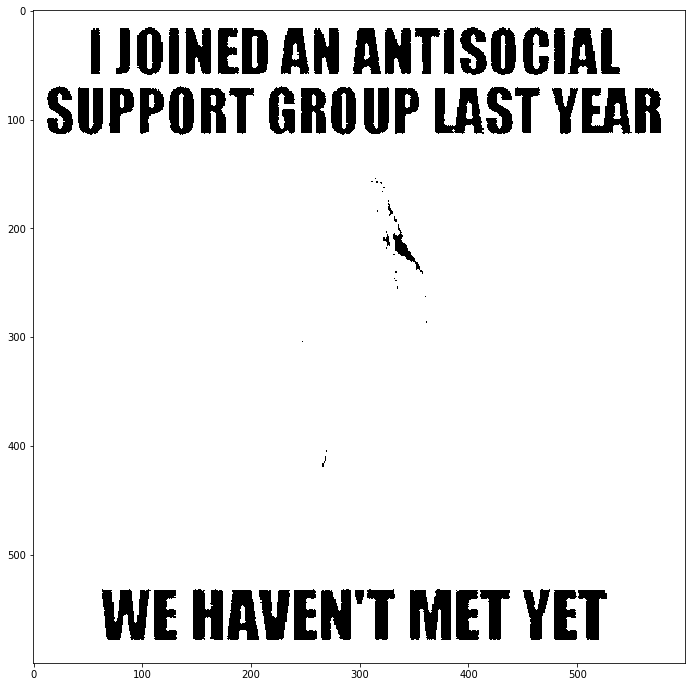

In [106]:
img = cv2.imread('images-text/sap4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

img_bin = img_gray > 245

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

img_dil = cv2.dilate(img_bin.astype('uint8'), kernel, iterations=1)
img_close = cv2.erode(img_dil.astype('uint8'), kernel, iterations=1)

img_inv = 255 - img_close

plt.imshow(img_inv, 'gray')